_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [ ]:

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

from sklearn.tree import DecisionTreeClassifier
import numpy as np

import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [ ]:
from sklearn import preprocessing
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE
def wrangle(df):
  df = pd.read_csv(url,
                  parse_dates = ['game_date'],
                  index_col = 'game_date',
                  dtype={'game_date':'object'})
  # Set the index to 'id'
  # df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='player_name', inplace=True)

  # Drop Duplicate Column
  # df.drop(columns='quantity_group', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # le = preprocessing.LabelEncoder()
  # cols_to_encode = [col for col in df.select_dtypes('object')]
  # for col in cols_to_encode:
  #   df[col] = list(le.fit(df[col].tolist()).classes_)

  # Drop columns with high proportion of zeros
  # df.drop(columns='num_private', inplace=True)

  #add feature columns 
  df['seconds_remaining_per']= df['minutes_remaining']*60 + df['seconds_remaining']
  df['seconds_remaining_tot']= (((4-df['period'])*12)*60) + df['minutes_remaining']*60 + df['seconds_remaining']
  
  return df

df = wrangle(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  13958 non-null  int64  
 1   game_event_id            13958 non-null  int64  
 2   period                   13958 non-null  int64  
 3   minutes_remaining        13958 non-null  int64  
 4   seconds_remaining        13958 non-null  int64  
 5   action_type              13958 non-null  object 
 6   shot_type                13958 non-null  object 
 7   shot_zone_basic          13958 non-null  object 
 8   shot_zone_area           13958 non-null  object 
 9   shot_zone_range          13958 non-null  object 
 10  shot_distance            13958 non-null  int64  
 11  loc_x                    13958 non-null  int64  
 12  loc_y                    13958 non-null  int64  
 13  shot_made_flag           13958 non-null  int64  
 14  htm  

In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [ ]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [ ]:
"""T2. Create new feature"""

# YOUR CODE HERE
df['seconds_remaining_per']= df['minutes_remaining']*60 + df['seconds_remaining']
df['seconds_remaining_tot']= (((4-df['period'])*12)*60) + df['minutes_remaining']*60 + df['seconds_remaining']


**Task 2 Test**

In [ ]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [ ]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns=target)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  13958 non-null  int64  
 1   game_event_id            13958 non-null  int64  
 2   period                   13958 non-null  int64  
 3   minutes_remaining        13958 non-null  int64  
 4   seconds_remaining        13958 non-null  int64  
 5   action_type              13958 non-null  object 
 6   shot_type                13958 non-null  object 
 7   shot_zone_basic          13958 non-null  object 
 8   shot_zone_area           13958 non-null  object 
 9   shot_zone_range          13958 non-null  object 
 10  shot_distance            13958 non-null  int64  
 11  loc_x                    13958 non-null  int64  
 12  loc_y                    13958 non-null  int64  
 13  htm                      13958 non-null  object 
 14  vtm  

**Task 3 Test**

In [ ]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [ ]:
# '''T4. Create training and val'''
# # YOUR CODE HERE


cutoff= '2017-07-01'
cutoff2= '2018-10-01'

mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask] 

X_val_0, y_val_0 = X.loc[~mask], y.loc[~mask]


In [ ]:
mask2 = X_val_0.index < cutoff2 
X_val = X_val_0.loc[mask2] 
y_val = y_val_0.loc[mask2] 
# # mask2 = cutoff1 < X.index < cutoff2 
X_test = X_val_0.loc[~mask2]
y_test = y_val_0.loc[~mask2]

In [ ]:
len(X_train)

11081

In [ ]:
len(X_val)

1168

In [ ]:
len(X_test)

1709

**Test 4**

In [ ]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


In [ ]:
X_train

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot,seconds_remaining_per,seconds_remaining_tot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,GSW,HOU,Regular Season,2.0,685,2845
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,GSW,HOU,Regular Season,0.0,571,2731
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,GSW,HOU,Regular Season,-4.0,362,2522
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,GSW,HOU,Regular Season,-4.0,589,2029
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,GSW,HOU,Regular Season,0.0,139,1579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-12,41600405,500,4,4,32,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,8,GSW,CLE,Playoffs,10.0,272,272
2017-06-12,41600405,503,4,4,13,Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-7,11,GSW,CLE,Playoffs,12.0,253,253
2017-06-12,41600405,527,4,1,37,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,28,1,283,GSW,CLE,Playoffs,11.0,97,97


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [ ]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [ ]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [ ]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE - random forest 
model = make_pipeline(
    #OneHotEncoder(use_cat_names = True),
    #LabelEncoder(),
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

model.fit(X_train, y_train);

**Task 6 Testing**

In [ ]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [ ]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc =  model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.6001712328767124


**Task 7 Test**

In [ ]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [ ]:
'''T8. Tune model.'''

# YOUR CODE HERE
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(1, 40, 1),
    'randomforestclassifier__max_samples': range(1,40,1),
    'randomforestclassifier__n_estimators': range(1,40,1),
    # 'randomforestclassifier__min_samples_leaf': range(1,40,1),
    
    
}

model_tune = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=None,
    verbose=1,
    n_iter = 3
)

model_tune.fit(X_val,y_val)

test_acc = model_tune.fit(X_test,y_test).best_score_

print('Testing Accuracy Score:', test_acc)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Testing Accuracy Score: 0.5512030320179726


In [ ]:
type(model_tune)  #RandomizedSearchCVobject

sklearn.model_selection._search.RandomizedSearchCV

In [ ]:
best_score = model_tune.best_score_
best_params = model_tune.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.5650049521294156
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 18, 'randomforestclassifier__max_samples': 25, 'randomforestclassifier__max_depth': 9}


In [ ]:
# median
# min samples leaf = 10
# max samples = 30
# max depth = 10 

**Task 8 Testing**

In [ ]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

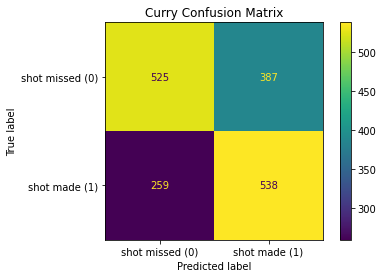

In [ ]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538+387) 
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [ ]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


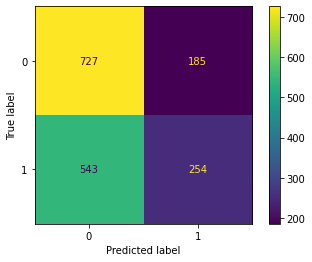

In [ ]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
plot_confusion_matrix(model_tune, X_test, y_test)  
plt.show()
